In [1]:
pathways = ["limonene", "isopentenol"]
pathway = pathways[1]

import pandas as pd
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import random
import matplotlib.pyplot as plt
from scipy.integrate import ode
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import math
import os
#import warnings
#warnings.simplefilter('ignore')

# Review

Predicting pathway dynamics is often done in systems biology using mathematical kinetic models, but they take a significant time to develop and necessitate deep biological expertise. Here, we want to show that a machine learning approach can infer pathway dynamics directly from experimental data. This approach can be systematically applied to any product, pathway or host and may have the potential to accelerate bioengineering efforts.

![title](img/centdog.gif)
Diagram: The central dogma of molecular biology. Source/License:

In [2]:
# metabolites
targets = ['Acetyl-CoA (uM)','HMG-CoA (uM)','Intracellular Mevalonate (uM)','Mev-P (uM)','IPP/DMAPP (uM)','Isopentenol g/L']

# proteins + other metabolites
features = ['OD600','ATP (uM)','AtoB','NudB','HMGR','HMGS','MK','PMK','PMD',
                        'NAD (uM)','NADP (uM)','Acetate g/L','Pyruvate g/L','citrate (uM)']

# isopentenol strains
strains, training_strains, test_strains = ['I1','I2','I3'], ['I1', 'I3'], ['I2'] #use isopentenol metabolic pathway


In [3]:
metabolite_file_name = os.path.join('data/', 'time_series_metabolomics.csv')

outputs = ['Acetyl-CoA (uM)','Acetyl-CoA extracellular (uM)',
                   'Acetoacetyl-coA (uM)','Acetoacetyl-CoA extracellular (uM)',
                   'HMG-CoA (uM)','HMG-CoA extracellular (uM)',
                   'Intracellular Mevalonate (uM)','MEVALONATE extracellular (uM)',
                   'Mev-P (uM)','MEV-P extracellular (uM)',
                   'IPP/DMAPP (uM)','IPP/DMAPP extracellular (uM)',
                   'GPP (uM)','GPP extracellular (uM)',
                   'Limonene g/L','ATP (uM)','OD600','NAD (uM)','NADP (uM)',
                   'Acetate g/L','Pyruvate g/L','citrate (uM)','Isopentenol g/L']

mdf = pd.read_csv(metabolite_file_name)
print(mdf.shape)
mdf = mdf.loc[mdf['Strain'].isin(strains)]
display(mdf[['Strain', 'Hour'] + targets])

(126, 91)


,Strain,Hour,Acetyl-CoA (uM),HMG-CoA (uM),Intracellular Mevalonate (uM),Mev-P (uM),IPP/DMAPP (uM),Isopentenol g/L
0,I1,0,0.196876,0.000000,0.003485,0.016535,2.641201,0.000000
1,I1,2,NaN,NaN,NaN,NaN,NaN,NaN
2,I1,4,0.492313,0.068923,0.275343,0.938668,18.247797,0.059590
3,I1,6,NaN,NaN,NaN,NaN,NaN,NaN
4,I1,8,NaN,NaN,0.595143,1.215891,17.163908,0.109851
5,I1,10,NaN,NaN,NaN,NaN,NaN,NaN
6,I1,12,0.449105,0.053514,0.523027,2.646922,32.728757,0.114827
7,I1,16,NaN,NaN,NaN,NaN,NaN,NaN
8,I1,18,0.343374,0.091403,0.673320,1.759246,24.578098,0.123507
9,I1,20,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# now we must interpolate missing values
mdf = mdf.reset_index()
mdf = mdf.interpolate(method ='linear', limit_direction ='forward')
mdf = mdf[['Strain','Hour'] + outputs].pivot_table(mdf[['Strain','Hour'] + outputs],index=['Strain','Hour'],aggfunc=np.sum)
display(mdf[targets])

Acetyl-CoA (uM)  HMG-CoA (uM)  Intracellular Mevalonate (uM)  \
Strain Hour                                                                 
I1     0            0.196876      0.000000                       0.003485   
       2            0.344594      0.034462                       0.139414   
       4            0.492313      0.068923                       0.275343   
       6            0.481511      0.065071                       0.435243   
       8            0.470709      0.061218                       0.595143   
       10           0.459907      0.057366                       0.559085   
       12           0.449105      0.053514                       0.523027   
       16           0.396240      0.072458                       0.598173   
       18           0.343374      0.091403                       0.673320   
       20           0.309091      0.097049                       0.690180   
       24           0.274808      0.102695                       0.707041   
       36           0.200513      0.116838                       0.635780   
       48           0.126218      0.130981                       0.645384   
       72           0.121400      0.070407                       0.536147   
I2     0            0.116582      0.009832                       0.012539   
       2            0.203723      0.055195                       0.632474   
       4            0.290864      0.100557                       1.252410   
       6            0.286805      0.107681                       2.005602   
       8            0.282745      0.114804                       2.758794   
       10           0.278686      0.121927                       3.216964   
       12           0.274626      0.129051                       3.675134   
       16           0.244999      0.133977                       3.948411   
       18           0.215372      0.138903                       4.221687   
       20           0.199694      0.149016                       4.202157   
       24           0.184017      0.159128                       4.182627   
       36           0.117034      0.087078                       4.169874   
       48           0.050052      0.015027                       3.914136   
       72           0.100736      0.007514                       4.226167   
I3     0            0.151420      0.000000                       0.014375   
       2            0.215479      0.003838                       0.559610   
       4            0.279537      0.007676                       1.104845   
       6            0.297987      0.007850                       1.388445   
       8            0.316437      0.008023                       1.672045   
       10           0.334888      0.008196                       1.718210   
       12           0.353338      0.008369                       1.764374   
       16           0.314555      0.007292                       1.792370   
       18           0.275773      0.006215                       1.820366   
       20           0.295301      0.007318                       1.975576   
       24           0.314829      0.008422                       2.130787   
       36           0.222333      0.015528                       2.086551   
       48           0.129837      0.022635                       1.986295   
       72           0.129837      0.022635                       2.204279   

             Mev-P (uM)  IPP/DMAPP (uM)  Isopentenol g/L  
Strain Hour                                               
I1     0       0.016535        2.641201         0.000000  
       2       0.477602       10.444499         0.029795  
       4       0.938668       18.247797         0.059590  
       6       1.077280       17.705853         0.084721  
       8       1.215891       17.163908         0.109851  
       10      1.931406       24.946333         0.112339  
       12      2.646922       32.728757         0.114827  
       16      2.203084       28.653427         0.119167  
       18      1.759246       24.5

Text(0.5, 0.98, 'Isopentenol Strain: Missing Data Interpolated')

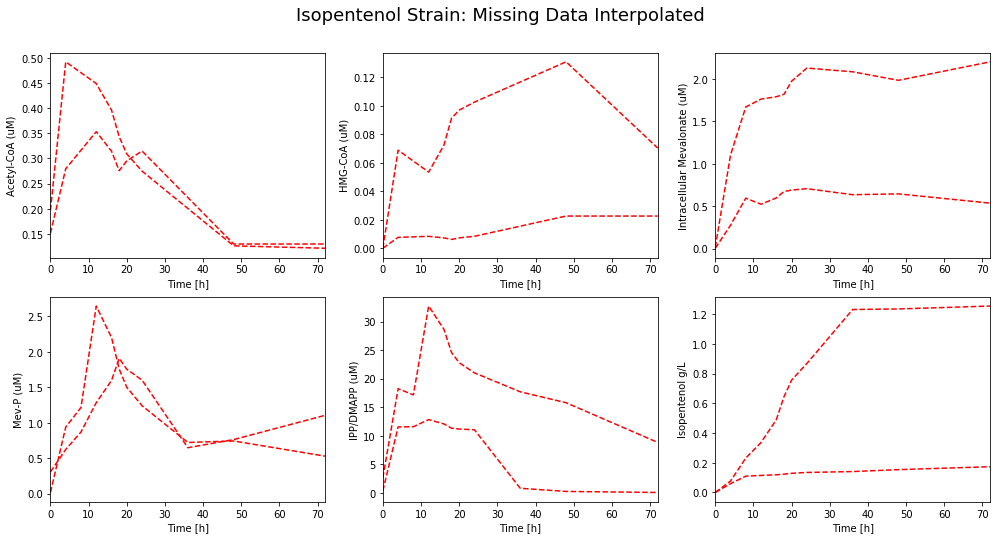

In [5]:
plt.figure(figsize=(14, 8))
for i, target in enumerate(targets):
    plt.subplot(2, 3, i + 1)
    for strain in training_strains:
        strain_df = mdf.loc[(strain,slice(None))]
        
        # handle missing data
        y = strain_df[target].tolist()
        X = strain_df.reset_index()['Hour'].tolist()
        train_line, = plt.plot(X, y,'r--')
    plt.ylabel(target)
    plt.xlabel('Time [h]')
    plt.xlim([0,72])
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.subplots_adjust(bottom=0.12)
plt.suptitle('Isopentenol Strain: Missing Data Interpolated', fontsize=18)

**Computing the derivative**: Given a set of data points (e.g. six in the example in the figure), an interpolated and smoothed time series is created from the measurements to reduce the noise of the signal and smooth the resulting derivative. The derivative of the time series is estimated by taking the derivative of the smoothed line at the time point of interest.

<img src="img/derivative.png" alt="Drawing" style="width: 600px;" align="centre"/>

This utility is implemented in bioLearningPractical as function `generateTSDataSet`.

Source/License:

In [6]:
from bioLearningPractical.generateTSDataSet import *
help(generateTSDataSet)

Help on function generateTSDataSet in module bioLearningPractical.generateTSDataSet:

generateTSDataSet(dataframe, features, targets, n_points=100)
    Modified by Kevin for bioLearningPractical
    
    Generate a smooth time-series data, interpolated from experimental measurements, and
    compute the time derivatives associated with the target variables.
    
    Args:
    - n_points = number of data points to interpolate
    - dataframe = the raw data (e.g. from experiments)
    - features = set of feature columns (metabolite + protein concentrations)
    - targets = set of target columns for which the time derivative is to be computed
    
    Return: a multi-index Pandas dataframe



In [9]:
#  Before computing derivatives, let's include protein data in the dataframe

protein_file_name = os.path.join('data/', 'time_series_proteomics.csv')
pdf = pd.read_csv(protein_file_name)

pdf = pdf.loc[pdf['Strain'].isin(strains)]
pdf = pdf.loc[~pdf['Hour'].isin(['72C'])]
pdf['Hour'] = pdf['Hour'].convert_objects(convert_numeric=True)
print(pdf['Protein'].unique())

proteins = ['AtoB','HMGR','HMGS','MK','PMD','PMK','Idi','GPPS','Limonene Synthase','NudB']
proteins = [('ProteinArea',protein) for protein in proteins]
columns = ['Strain','Hour','Protein','ProteinArea']

# we want to get a time series from 'Protein' column 
pdf = pdf[columns].pivot_table(pdf[columns],index=['Strain','Hour'],columns='Protein',aggfunc=np.sum)
pdf = pdf[proteins]
pdf.columns = pdf.columns.get_level_values(1)
display(pdf)

['AtoB' 'Bisabolene' 'HMGR' 'HMGS' 'Idi' 'IspA' 'Limonene Synthase' 'MK'
 'NudB' 'PMD' 'PMK' '6PGD' 'FRDA' 'CAPP' 'LACI' 'FUMC' 'K6PF2' 'DHSB'
 'FDHF' 'IDH' 'PFLB' 'ACKA' 'ENO' 'G6PI' 'K6PF1' 'PGK' 'RPIA' 'SUCC'
 'TPIS' 'TALA' 'TALB' 'FRDC' 'FRDD' 'F16PA' 'G3P1' 'GLPX' 'PTA' 'DLDH'
 'ADHE' 'HYCB' 'ALF' 'CISY' 'FUMA' 'DHSA' 'DHSD' 'FRDB' 'G6PD' 'KPYK1'
 'ODO1' 'ODO2' 'SUCD' 'HYCC' 'HYCD' 'HYCE' 'HYCF' 'HYCG' 'GLPX2' 'KPYK2'
 'YBHA' 'PCKA' 'PPSA' 'ACON1' 'MAO1' 'TKT1' 'ACSA' 'TKT2' 'MQO' 'ACON2'
 'RPIB' 'GPMI' 'MDH' 'GPMA' 'DHSC' 'MAO2' 'EUTD' 'GPPS' 'AMPR' 'Cam' 'BSA']


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


Protein            AtoB      HMGR       HMGS        MK         PMD       PMK  \
Strain Hour                                                                    
I1     0         7419.0  141338.0    17643.0   75815.0    389085.0   71808.0   
       4      2274423.0  141742.0   354612.0  114635.0  16988996.0  121497.0   
       8      2569281.0   93624.0   400406.0  130112.0  18636906.0  127708.0   
       12     2924101.0  126483.0   465989.0  152303.0  22200000.0  134870.0   
       18     2648967.0  111784.0   387501.0  122471.0  18586524.0  131392.0   
       24     2801056.0  108034.0   434153.0  123257.0  19867674.0  139603.0   
       36     2986061.0  106361.0   457308.0  139122.0  22400000.0  139199.0   
       48     2993954.0  121696.0   475405.0  136302.0  21800000.0  151537.0   
       72     2764457.0  108521.0   462373.0  120807.0  22400000.0  135908.0   
I2     0        27275.0   57676.0    52787.0   36011.0    678408.0   23841.0   
       4      6356472.0  425947.0  2656860.0   94519.0  17942304.0  113870.0   
       8      7570699.0  556435.0  3188444.0  117660.0  21800000.0  146750.0   
       12     8125184.0  533713.0  3566712.0  163812.0  22200000.0  164444.0   
       18     7235323.0  303509.0  3435902.0  178212.0  20000000.0  187277.0   
       24     9222170.0  285957.0  4248609.0  235162.0  22000000.0  197678.0   
       36     8506980.0  249896.0  4049213.0  236821.0  20600000.0  190427.0   
       48     9743705.0  291195.0  5003631.0  325334.0  25200000.0  201404.0   
       72    10122404.0  304540.0  5580503.0  307217.0  26200000.0  196181.0   
I3     0        17795.0   21408.0    44671.0   99246.0    374799.0   77713.0   
       4      2663099.0  205427.0  1017967.0  199689.0  15412143.0  161022.0   
       8      2530375.0  253650.0  1109560.0  227000.0  18259860.0  176889.0   
       12     2562264.0  209587.0   949897.0  218289.0  16952356.0  194116.0   
       18     3303070.0  268929.0  1226232.0  300752.0  20400000.0  251856.0   
       24     3290972.0  273758.0  1112970.0  312762.0  19337520.0  243817.0   
       36     3185590.0  242074.0  1041137.0  307282.0  19927044.0  246806.0   
       48     2969012.0  237745.0  1018029.0  304946.0  19781988.0  230316.0   
       72     3009723.0  243739.0  1046921.0  353697.0  22600000.0  213419.0   

Protein         Idi    GPPS  Limonene Synthase        NudB  
Strain Hour                                                 
I1     0     2726.0  3678.0             1956.0     91185.0  
       4     3246.0  3762.0             1611.0   6959635.0  
       8     4406.0  3065.0             1620.0   7959617.0  
       12    7202.0  3403.0             3956.0   8935320.0  
       18    3170.0  4371.0             1618.0   8294957.0  
       24    5511.0  3142.0             2560.0   8409057.0  
       36    5939.0  4699.0              821.0   8703974.0  
       48    6051.0  3998.0             2150.0   9535746.0  
       72    5752.0  5793.0             2290.0   8654013.0  
I2     0     5489.0  5198.0             2509.0    127761.0  
       4     3328.0  3315.0             2141.0   7400487.0  
       8     4686.0  4067.0             3479.0  10848951.0  
       12    6335.0  4265.0             1748.0  13427844.0  
       18    6268.0  4169.0             2228.0  12142854.0  
       24    6271.0  3561.0             2869.0  14627487.0  
       36    6969.0  1844.0             1487.0  14219619.0  
       48    7431.0  6425.0             3728.0  17458768.0  
       72    7587.0  2654.0             1082.0  18159070.0  
I3     0     3974.0  4248.0             1393.0     91047.0  
       4     6301.0  5300.0             3363.0   7737700.0  
       8     6223.0  5123.0             3508.0   9257004.0  
       12    7150.0  3139.0              988.0   9826814.0  
       18    8456.0  5954.0             1048.0  15204452.0  
       24    7280.0  4027.0             2607.0  15674525.0  
       36    9594.0  4704.0             2883.0  14995967.0  
       48    8331.0  3847.0     

In [13]:
all_df = pd.concat([pdf, mdf], axis=1)
all_df = all_df.interpolate(method ='linear', limit_direction ='forward')
train_df = all_df.loc[(training_strains,slice(None))]
test_df = all_df.loc[(test_strains,slice(None))]

train_tsdf = generateTSDataSet(train_df, features, targets, n_points=100)
train_tsdf.to_pickle(os.path.join('data/processed/', 'tsdf_' + pathway + '.pkl'))

# save processed files to disk
train_df.to_pickle(os.path.join('data/processed/', 'train_' + pathway + '.pkl'))
test_df.to_pickle(os.path.join('data/processed/', 'test_' + pathway + '.pkl'))

test_tsdf = generateTSDataSet(test_df,features,targets, n_points=100)
display(test_tsdf)

Total Time Series in Data Set:  2
Total Time Series in Data Set:  1


feature                                        \
                     OD600  ATP (uM)          AtoB          NudB   
Strain Time (h)                                                    
I2     0.000000   0.602476  0.147164  1.000000e-09  8.637288e+04   
       0.727273   0.908623  0.169182  1.211252e+06  1.474908e+06   
       1.454545   1.205247  0.190610  2.395229e+06  2.822054e+06   
       2.181818   1.492346  0.211447  3.523850e+06  4.127813e+06   
       2.909091   1.787065  0.232756  4.696756e+06  5.466682e+06   
       3.636364   2.047498  0.251939  5.670377e+06  6.656554e+06   
       4.363636   2.258407  0.268050  6.356143e+06  7.631207e+06   
       5.090909   2.419792  0.281089  6.754053e+06  8.390643e+06   
       5.818182   2.546892  0.292002  6.952679e+06  9.001081e+06   
       6.545455   2.672952  0.302678  7.140586e+06  9.610022e+06   
       7.272727   2.802476  0.313828  7.355643e+06  1.022949e+07   
       8.000000   2.923688  0.324977  7.536427e+06  1.080378e+07   
       8.727273   3.035203  0.336126  7.677227e+06  1.132537e+07   
       9.454545   3.138407  0.347275  7.783754e+06  1.180179e+07   
       10.181818  3.241649  0.359004  7.881798e+06  1.228351e+07   
       10.909091  3.345565  0.370443  7.986940e+06  1.276635e+07   
       11.636364  3.430604  0.379271  8.053144e+06  1.312367e+07   
       12.363636  3.488377  0.384325  8.063103e+06  1.329971e+07   
       13.090909  3.518883  0.385607  8.016819e+06  1.329445e+07   
       13.818182  3.530513  0.384276  7.931596e+06  1.316369e+07   
       14.545455  3.538738  0.382755  7.849751e+06  1.303011e+07   
       15.272727  3.553119  0.381665  7.765002e+06  1.290773e+07   
       16.000000  3.571232  0.380206  7.644687e+06  1.273565e+07   
       16.727273  3.593634  0.378291  7.478726e+06  1.250016e+07   
       17.454545  3.621387  0.376623  7.383052e+06  1.235368e+07   
       18.181818  3.654327  0.375737  7.440088e+06  1.240526e+07   
       18.909091  3.688108  0.375919  7.668648e+06  1.268288e+07   
       19.636364  3.720091  0.376760  7.989262e+06  1.308345e+07   
       20.363636  3.747253  0.377705  8.297555e+06  1.347122e+07   
       21.090909  3.768357  0.378282  8.512582e+06  1.374012e+07   
...                    ...       ...           ...           ...   
       50.909091  3.340152  0.082057  9.789608e+06  1.754365e+07   
       51.636364  3.333939  0.083491  9.801084e+06  1.756487e+07   
       52.363636  3.327727  0.084926  9.812559e+06  1.758610e+07   
       53.090909  3.321515  0.086360  9.824035e+06  1.760732e+07   
       53.818182  3.315303  0.087794  9.835511e+06  1.762854e+07   
       54.545455  3.309091  0.089228  9.846987e+06  1.764976e+07   
       55.272727  3.302879  0.090663  9.858462e+06  1.767098e+07   
       56.000000  3.296667  0.092097  9.869938e+06  1.769220e+07   
       56.727273  3.290455  0.093531  9.881414e+06  1.771342e+07   
       57.454545  3.284242  0.094965  9.892889e+06  1.773464e+07   
       58.181818  3.278030  0.096400  9.904365e+06  1.775587e+07   
       58.909091  3.271818  0.097834  9.915841e+06  1.777709e+07   
       59.636364  3.265606  0.099268  9.927317e+06  1.779831e+07   
       60.363636  3.259394  0.100702  9.938792e+06  1.781953e+07   
       61.090909  3.253182  0.102136  9.950268e+06  1.784075e+07   
       61.818182  3.246970  0.103571  9.961744e+06  1.786197e+07   
       62.545455  3.240758  0.105005  9.973220e+06  1.788319e+07   
       63.272727  3.234545  0.106439  9.984695e+06  1.790441e+07   
       64.000000  3.228333  0.107873  9.996171e+06  1.792564e+07   
       64.727273  3.222121  0.109308  1.000765e+07  1.794686e+07   
       65.454545  3.215909  0.110742  1.001912e+07  1.796808e+07   
       66.181818  3.209697  0.112176  1.003060e+07  1.798930e+07   
       66.909091  3.203485  0.113610  1.004207e+07  1.801052e+07   
       67.636364  3.197273  0.115045  1.005355e+07  1.803174e+07   
       68.363636  3.191061  0.116479  1.006503e+07  1.805296e+07   
       

# Model Fitting

To make things easier, we will use random forest regressor, instead of training multiple models on different targets.The final ML models (found by TPOT) used by the author of the original paper [Costello & Martin, Nature 2018](https://www.nature.com/articles/s41540-018-0054-3) are listed below.


<img src="img/ml-model-list.png" alt="Drawing" style="width: 800px;" align="left"/>

In [14]:
mlmodel = RandomForestRegressor(n_estimators=100)

modelDict = {}
average_training_score = 0
n = 0
for target_index in train_tsdf.columns:
    if target_index[0] == 'feature':
        continue
    n += 1
    target = target_index[1]
    print("Processing target: ", target)

    X = train_tsdf['feature'].values.tolist()
    y = train_tsdf[target_index].values.tolist()
    
    modelDict[target] = clone(mlmodel)
    modelDict[target] = modelDict[target].fit(X,y)
    
    score = modelDict[target].score(X,y)
    print('Cross Validated Pearson R: {:f}'.format(score))
    average_training_score +=  score
    
average_training_score /= n
print('Average Training Score:',average_training_score)

Processing target:  Acetyl-CoA (uM)
Cross Validated Pearson R: 0.990666
Processing target:  HMG-CoA (uM)
Cross Validated Pearson R: 0.967470
Processing target:  Intracellular Mevalonate (uM)
Cross Validated Pearson R: 0.969928
Processing target:  Mev-P (uM)
Cross Validated Pearson R: 0.967348
Processing target:  IPP/DMAPP (uM)
Cross Validated Pearson R: 0.989125
Processing target:  Isopentenol g/L
Cross Validated Pearson R: 0.993303
Average Training Score: 0.9796399319199178


In [15]:
## We need a few more helper functions to perform the integration
##
from bioLearningPractical.integrator import *

help(mlode)

Help on function mlode in module bioLearningPractical.integrator:

mlode(modelDict, df, targets, specific_features, time_index='Time (h)')
    Modified by Kevin for bioLearningPractical.
    Create the function f(x, t), i.e. the RHS of the ODE, learned by the ML model.
    
    Args:
    - modelDict: a dictionary containing the trained model for each target variable.
    - df: a data frame (can be multi-index)!
    - targets: a list of target columns
    - specific_features: a dictionary of features for each target



In [33]:
specific_features = {target: train_tsdf['feature'].columns.values.tolist() for target in targets}

## define the Initial Value Problem
y0 = test_df[targets].iloc[0].tolist()
print(test_tsdf['target'].columns)
print('Initial conditions: ',y0)

g = mlode(modelDict, test_df, targets, specific_features, time_index='Hour') #derivative of concentration wrt time
times = test_df.reset_index()['Hour'].tolist()
fit = odeintz(g, y0, times) #integrate g with initial conditions y0
fitT = list(map(list, zip(*fit)))

Index(['Acetyl-CoA (uM)', 'HMG-CoA (uM)', 'Intracellular Mevalonate (uM)',
       'Mev-P (uM)', 'IPP/DMAPP (uM)', 'Isopentenol g/L'],
      dtype='object')
Initial conditions:  [0.116582264, 0.009832111999999999, 0.012538565, 0.307744008, 10.08837077, 0.0]


In the paper, it was shown that with only two time-series (strains) as training data:
* Overall, the ML predictions agree qualitatively with the test data, with only one exception (red band)
* Green color band: for Acetyl-CoA and isopentenol (i.e. the final product), ML predictions quantitatively agree with the test data
* Yellow color band: ML model qualitatively reproduces the metabolite patterns, missing some scale factor
* Red color band: Quantitative and qualitative failure for HMG-CoA

The experimentally measured profiles correspond to high, low and medium producers of isopentenol. The training sets are the low and high producers (in red) and the model (blue line) is used to predict the concentrations for the medium producing strain (in green).

![title](img/fig5_isopentenol.png)

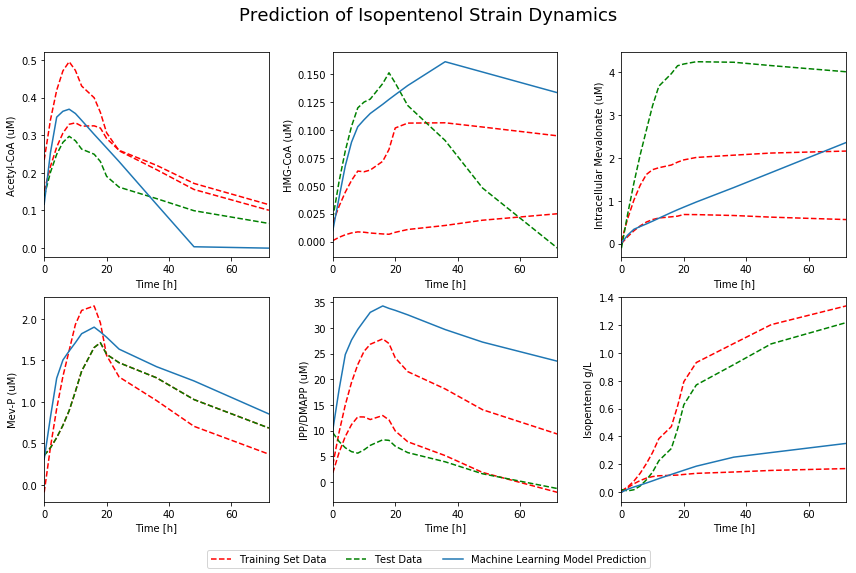

In [35]:
real_vs_predicted = {}
plt.figure(figsize=(12,8))
for i,target in enumerate(targets):
    
    plt.subplot(2,3,i+1)

    #Plot the two high and low strains
    for strain in training_strains:
        strain_df = train_df.loc[(strain,slice(None))]
    
        y = strain_df[target].tolist()
        X = strain_df.reset_index()['Hour'].tolist()
        trainInterpFun = interp1d(X,y) #create an interpolation function
        actual_data = savgol_filter(trainInterpFun(times), 9, 2)
        train_line, = plt.plot(times, actual_data,'r--')
    
    for strain in test_strains:
        strain_df = test_df.loc[strain, slice(None)]
        X, y = strain_df.reset_index()['Hour'].tolist(), strain_df[target].tolist()
        interpFun = interp1d(X,y) #create an interpolation function
        actual_data = savgol_filter(interpFun(times), 9, 2)
        test_line, = plt.plot(times, actual_data,'g--')
    
    pos_pred = [max(fitT[i][j], 0) for j,t in enumerate(times)]
    prediction_line, = plt.plot(times,pos_pred)

    plt.ylabel(target)
    plt.xlabel('Time [h]')
    plt.xlim([0,72])

    #Create variable for processing error residuals
    real_vs_predicted[target] = [times,actual_data,pos_pred]
    
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.subplots_adjust(bottom=0.12)
plt.suptitle('Prediction of Isopentenol Strain Dynamics', fontsize=18)
plt.figlegend( (train_line,test_line,prediction_line), ('Training Set Data','Test Data','Machine Learning Model Prediction'), loc = 'lower center', ncol=5, labelspacing=0. ) 
plt.savefig('figures/isopentenol_prediction.eps', format='eps', dpi=600)
plt.show()

Total number of species as features:  14


Text(0.5, 0.98, 'Protein data: isopentenol pathway')

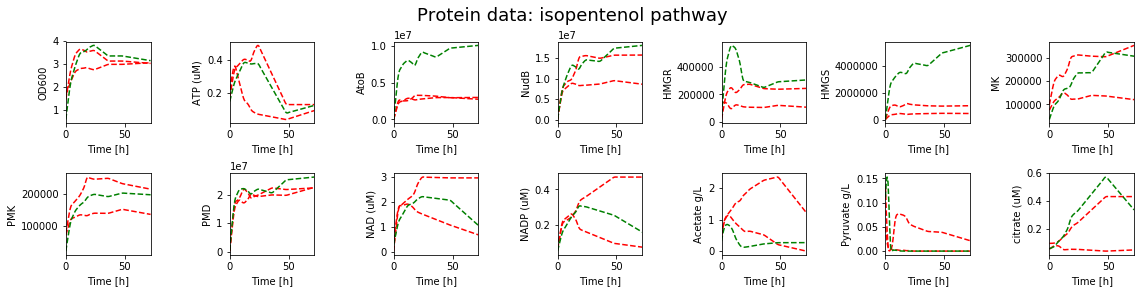

In [56]:
# plot the features: train, test.
print("Total number of species as features: ", len(features))

plt.figure(figsize=(16, 4))
for i, target in enumerate(features):
    plt.subplot(2, 7, i + 1)
    for strain in training_strains:
        strain_df = train_tsdf['feature'].loc[(strain,slice(None))]
        
        # handle missing data
        y = strain_df[target].tolist()
        X = strain_df.reset_index()['Time (h)'].tolist()
        train_line, = plt.plot(X, y,'r--')
        
    for strain in test_strains:
        strain_df = test_tsdf['feature'].loc[(strain,slice(None))]
        
        # handle missing data
        y = strain_df[target].tolist()
        X = strain_df.reset_index()['Time (h)'].tolist()
        test_line, = plt.plot(X, y,'g--')
    plt.ylabel(target)
    plt.xlabel('Time [h]')
    plt.xlim([0,72])
plt.tight_layout()
plt.subplots_adjust(top=0.86)
plt.subplots_adjust(bottom=0.12)
plt.suptitle('Protein data: isopentenol pathway', fontsize=18)